# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from os.path import exists, dirname
import os, sys
from nap import *

# Data wrangling

### Resources used

In [3]:
# Files:
## New pickle files to process and to push to firebase
push_these_pickles_to_firebase_list = []#'C5_align_v2_0mut', 'C5_align_v2_1mut'] # PICKLES FILES TO PUSH TO THE FIREBASE HERE 
other_C5 = []# ['C5_q40', 'C5_bt2v2343','C5_bt2343_q40','C5_Harrish']

## Pickle files to load for this experiment
pickles = data_wrangler.generate_pickles(path_to_data='data/FULLSET',
                            letters_boundaries = ('A','H'),
                            number_boundaries= (1,10),
                            pickles_list= [] +other_C5 + push_these_pickles_to_firebase_list,
                            remove_pickles=['C3','C10','D10','E10','F10','G10','H10', 'E4'])

push_these_pickles_to_firebase = {k: v for k, v in pickles.items() if k in push_these_pickles_to_firebase_list}

## Data files paths
json_file = 'data/db.json'
RNAstructureFile = 'data/delta_g_plus_bracket_q1.csv'

## Constants
min_bases_cov = 1000 
user = 'Yves'

### Load the data

Process new pickle files and push them to Firebase

In [4]:
# If the user gives some new pickles files, push them to the firebase, then pull the entire firebase
if len(push_these_pickles_to_firebase):
    data_wrangler.push_pickles_to_firebase(pickles = push_these_pickles_to_firebase,
                                            RNAstructureFile = RNAstructureFile,
                                            min_bases_cov = min_bases_cov, 
                                            user=user)
    if exists(json_file):
        os.remove(json_file)

In [5]:
# If not local copy of firebase, pull the firebase, else, load your copy
if not exists(json_file):
    if not exists('data'):
        os.mkdir('data')
    df_rough = data_wrangler.load_data_from_firebase(tubes = pickles.keys(), user=user)
    data_wrangler.dump_dict_json(JSONFileDict=json_file,
                                 df=df_rough)
else:
    df_rough = data_wrangler.load_dict_json(json_file)

No local file found, load data from Firebase
A1 A2 A3 A4 A5 A6 A7 A8 A9 A10 B1 B2 B3 B4 B5 B6 B7 B8 B9 B10 C1 C2 C4 C5 C6 C7 C8 C9 D1 D2 D3 D4 D5 D6 D7 D8 D9 E1 E2 E3 E5 E6 E7 E8 E9 F1 F2 F3 F4 F5 F6 F7 F8 F9 G1 G2 G3 G4 G5 G6 G7 G8 G9 H1 H2 H3 H4 H5 H6 H7 H8 H9 Done!
Dumping df as a dict to a JSON file data/db.json
Done!


### Clean and reformat the dataset. 
`df` is used for the analysis. Each of the construct have above 1000 reads for each tube.     
`df_full` is used for quality quality analysis. It has all constructs above 1000 valid reads for each tube individually.

In [6]:
df, df_full = turner_overthrow.clean_dataset(df_rough=df_rough,
                                             tubes=pickles.keys(), 
                                             min_bases_cov=min_bases_cov)

/home/ymdt/NAP/nap.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['tubes_covered'].loc[construct[1].index] = construct[1]['sequence'].count()


31 constructs were dropped because deltaG was 'void'
66 constructs have more than 1000 reads for each base of their var part on each tube


# Data quality analysis

In [7]:
## Select - or not - to use this part
data_quality_analysis = True

### Show the tube's quantity of valid structures (good indicator of the tube's quality)

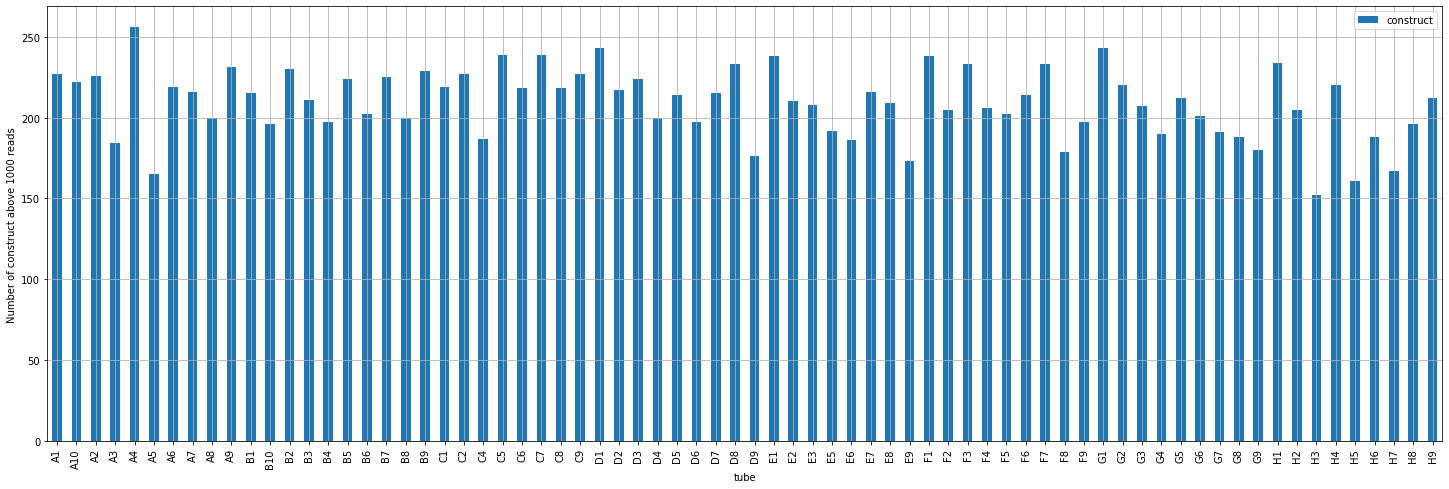

In [8]:
if data_quality_analysis:
    plot.valid_construct_per_tube(df=df_full,
                              min_bases_cov=min_bases_cov)

### Show the tube coverage distribution

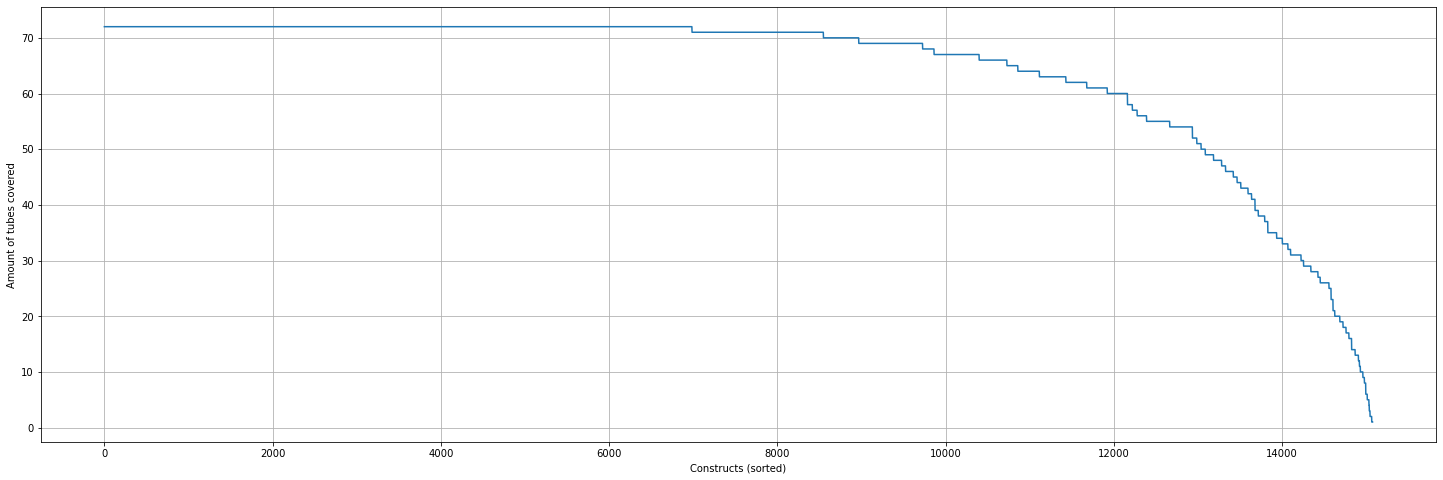

In [9]:
if data_quality_analysis:
    plot.tube_coverage_distribution(df=df_full)

### Plot the base coverage per construct distribution

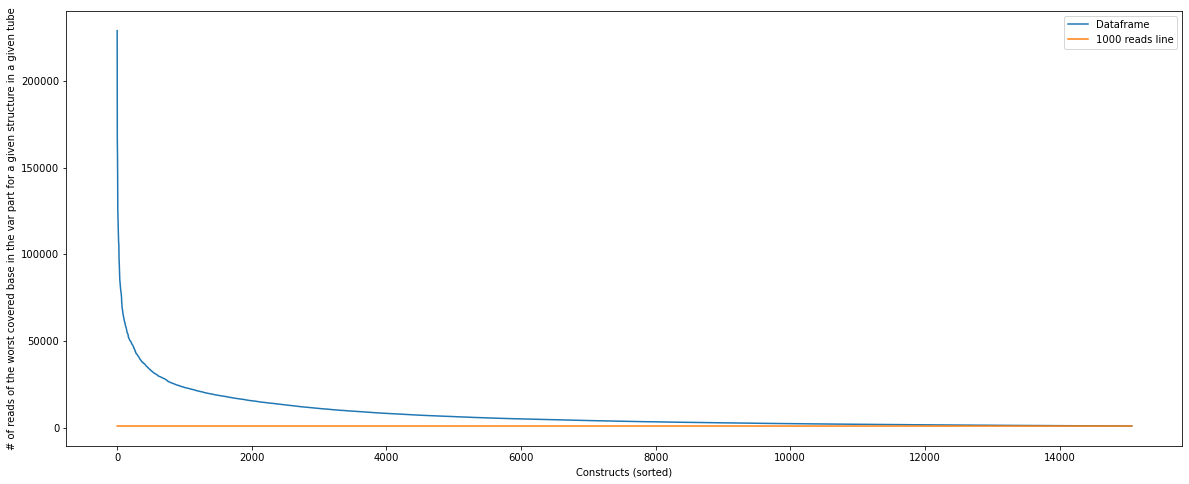

In [10]:
if data_quality_analysis:
    plot.base_coverage_for_all_constructs(df=df_full, 
                                      min_bases_cov=min_bases_cov)
print_num_reads = False
if print_num_reads:
    df.pivot('construct','tube','num_reads').to_csv('num_reads_realignment_v2.csv')

### Sanity-check construct-wise base coverage plots
Plot randomly picked sequences to check the quality of the data.

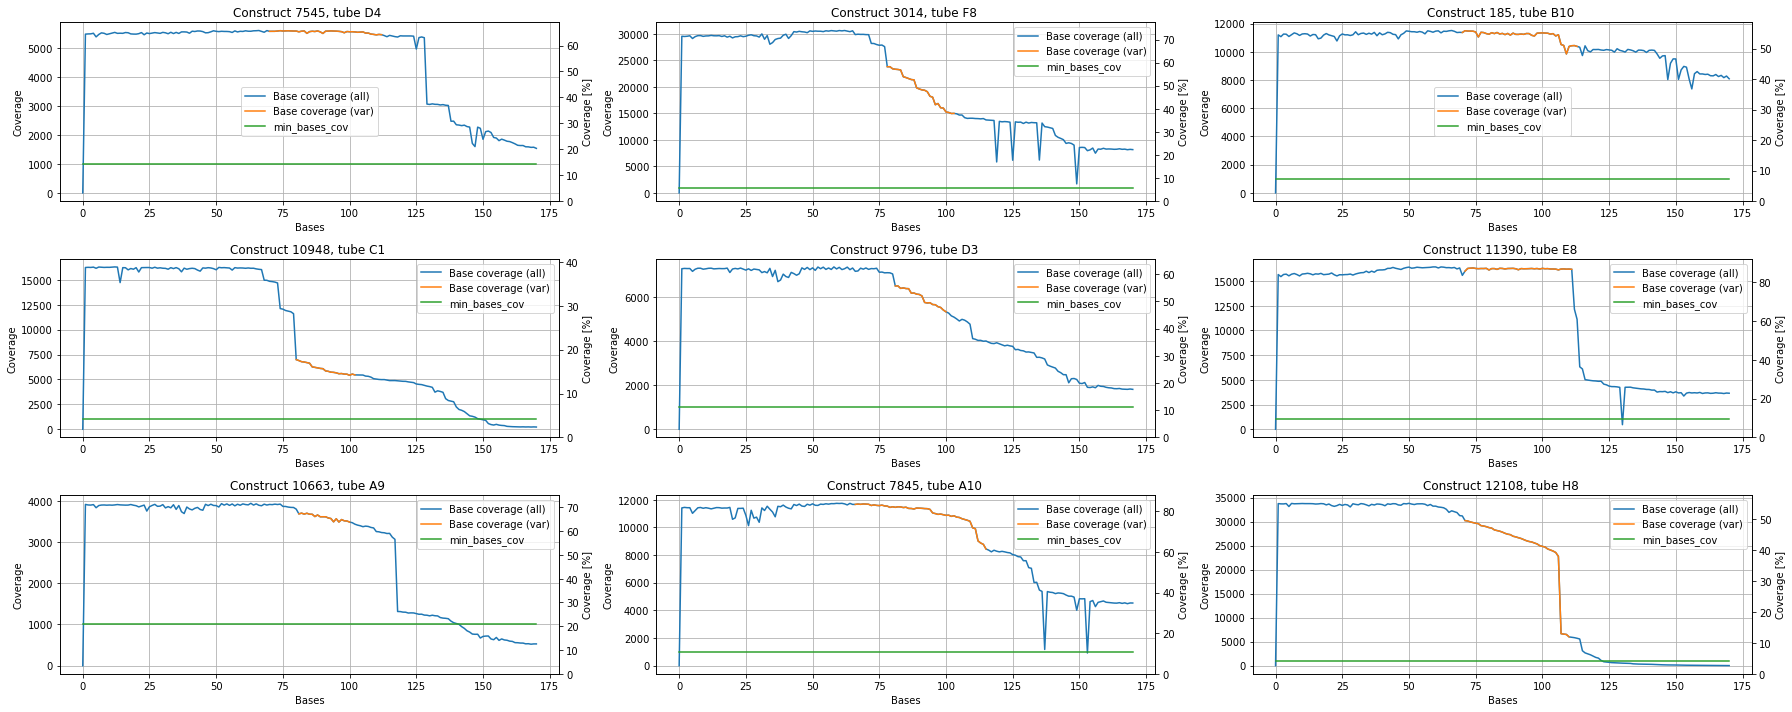

In [11]:
if data_quality_analysis:
    plot.random_base_coverage_plot_wise(df=df, 
                                    min_bases_cov=min_bases_cov)

### Heatmap of the var part coverage

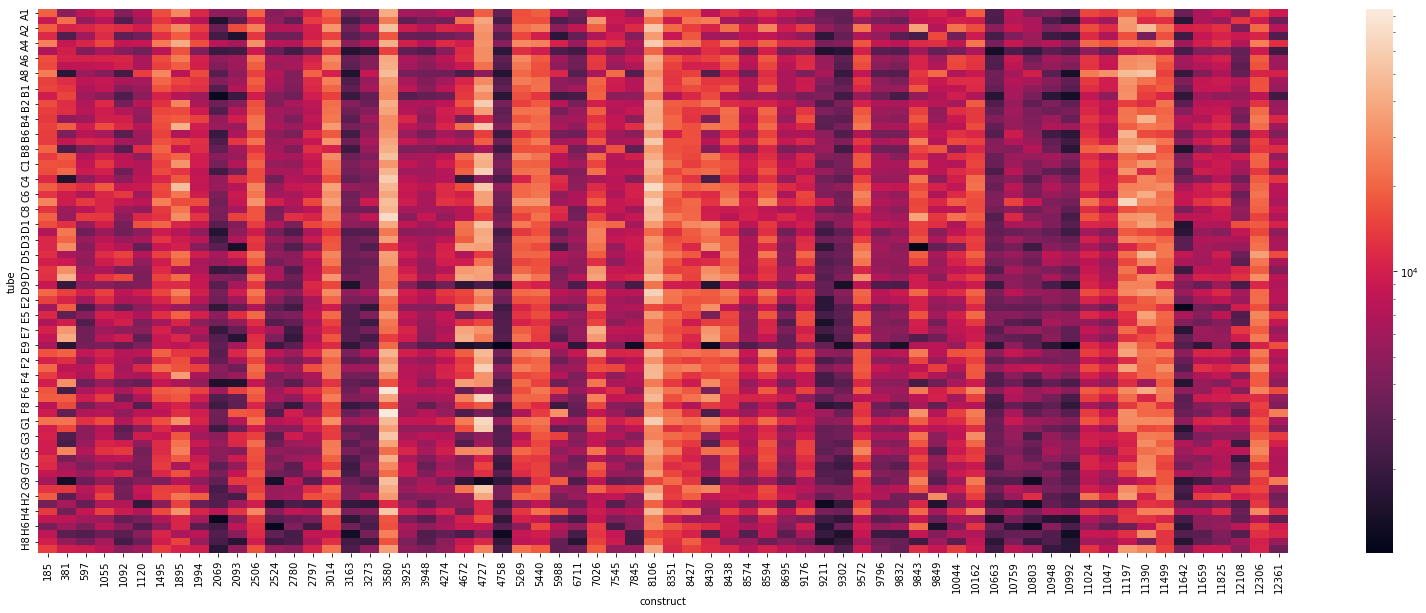

In [12]:
if data_quality_analysis:
    plot.heatmap(df = df, 
             column="cov_bases_var")

### Heatmap of the second half coverage

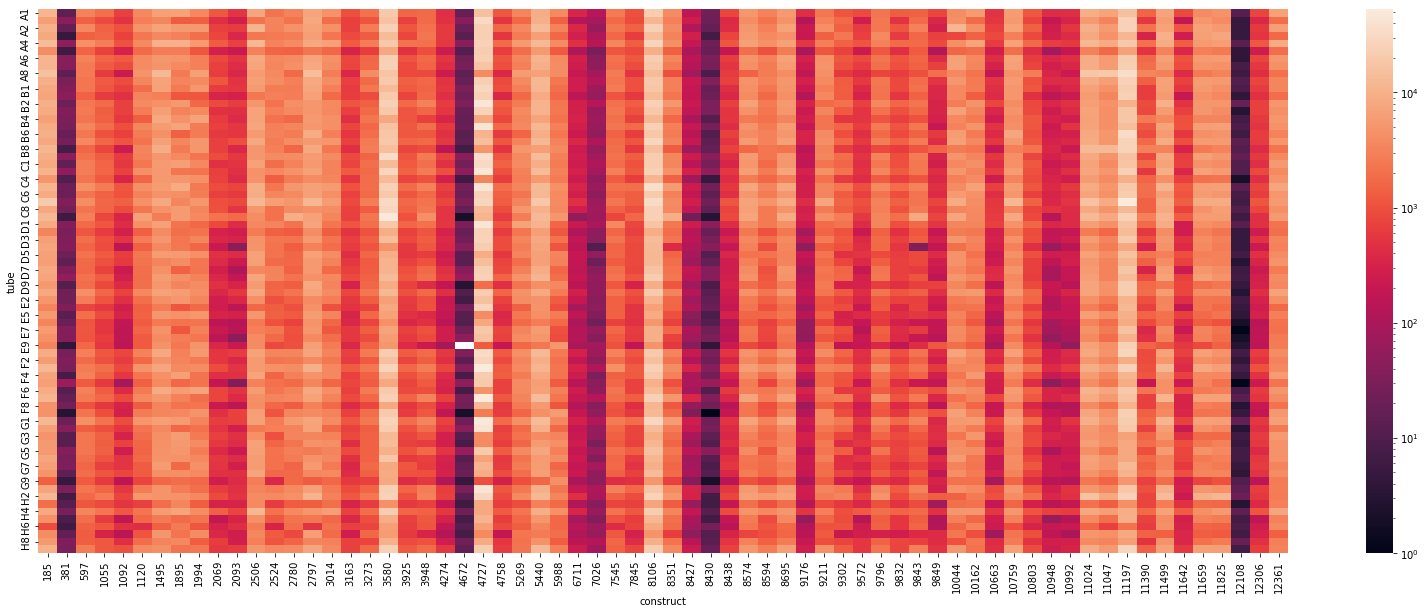

In [13]:
if data_quality_analysis:
    plot.heatmap(df = df, 
                column="cov_bases_sec_half")

# Data Analysis

### Define variables

In [14]:
### EDIT INPUTS HERE
study = '60_mM_DMS_kinestics'  
show_plots = False
constructs = df.construct.unique()
analyse = {'base_per_base_partition':False,
           'base_per_base_sequence': False,
           'deltaG': True,
           'tube_comparison':True,
           'columns_csv': True,
           'deltaG_construct': True
            }
# END OF EDIT ZONE

tubes_per_study = {'replicates':['C5','A4' , 'F4', 'A6', 'A7'],
                      'salt': ['A6','B6','C6','D6','E6'], 
                      'temperature':['D7','E7','F7','G7','H7','A8','B8','C8'], 
                      'C5_diff_processings': list(filter(lambda p: 'C5' in p, pickles)),
                      'magnesium':['F6', 'G6', 'H6', 'A7', 'B7', 'C7'],
                      '60_mM_DMS_kinestics':['D8', 'E8', 'F8', 'G8', 'H8', 'A9']
                      }

tubes = tubes_per_study[study]

### Big script to run every selected function

In [ ]:
utils.big_script(df=df, tubes=tubes, constructs=constructs, analyse=analyse, study=study)

### Explore the data
`utils.get_var_info(df=df, tube=tube, construct=construct)` gives information about the variable part of the given construct of a given tube.

In [ ]:
tube, construct = tubes[0], constructs[0]
#utils.get_var_info(df=df, tube=tube, construct=construct).xs((True, '0'),level=('paired','var_structure_comparison'))

### Mutation sequence-wise

`plot.mutation_rate(df, tube, construct, plot_type, index, normalize)` plots the mutation rate base-wise for a given construct of a given tube as a barplot. 
Arguments:
- `plot_type` :
    - `'sequence'` : each bar is colored w.r.t to the base of the original sequence.
    - `'partition'` : each bar shows the partition of into which bases this base mutates.
- `index`:
    - `'index'`: each base is identified with its position number
    - `'base'`: each base is identified with its type (A, C, G, T)

Partition type - non normalized

In [ ]:
for tube in tubes:
    for construct in constructs:
        plot.mutation_rate(df, tube, construct, plot_type='partition', index='base')  
        plot.save_fig(path=f"data/figs/date/{study}/mut_per_base/partition/{construct}/", 
                    title=f"base_per_base_partition_{tube}_{construct}")
        plt.close(not show_plots)

Sequence type

In [ ]:
for tube in tubes:
    for construct in constructs:
        plot.mutation_rate(df=df,
                           tube=tube,
                           construct=construct,
                           plot_type='sequence',
                           index='index')
        plot.save_fig(path=f"data/figs/date/{study}/mut_per_base/sequence/{construct}/", 
                    title=f"base_per_base_sequence_{tube}_{construct}")
        plt.close(not show_plots)

### DeltaG plots

In [ ]:
for tube in tubes:
    plot.deltaG(df=df, tube=tube)

    plot.save_fig(path=f"data/figs/date/{study}/deltaG/", 
             title=f"deltaG_{tube}")

    plt.close(not show_plots)

### Tubes comparison

In [ ]:
for construct in constructs:
        plot.compare_n_tubes(df, tubes, construct)
        plot.save_fig(path=f"data/figs/date/comparison/{study}", 
                      title=f"comparison_{study}_{construct}")
        plt.close(not show_plots)
        print(construct, end=' ')

### Save columns to a csv file

In [15]:
utils.columns_to_csv(df=df,
                   tubes=tubes,
                   columns=['tube', 'construct','full_sequence','var_sequence','mut_bases','info_bases'],
                   title='seq_and_reactivity_{study}',
                   path='data/figs/date/{study}'
                   )

/home/ymdt/NAP/nap.py:489: RuntimeWarning: invalid value encountered in true_divide
  df_print['mut_rate'] = df_print.apply(lambda row: np.float32(np.array(row['mut_bases'])/np.array(row['info_bases'])), axis=1)


### Save construct vs deltaG 

In [ ]:
def deltaG_vs_construct_to_csv(df, title, path, tubes):
    full_path = utils.make_path(path)
    df[df['tube']==tubes[0]][['construct','var_deltaG','full_deltaG']].reset_index().drop(columns=['index']).to_csv(f"{full_path}/{title}")
    
deltaG_vs_construct_to_csv(df=df, title=f"deltaG_vs_construct.csv", path = f"data/figs/date", tubes=tubes)